In [34]:
import numpy as np
import pandas as pd
from matplotlib import pyplot
from astropy.io import fits
import os
import healpy as hp

import plotting
import auxil_ML as aux
import healpylib3 as hlib




In [35]:
def accuracy_score(y_true, y_pred):
    return np.sum(y_true == y_pred) / len(y_true)

In [68]:
plotting.setup_figure_pars()
save_plots = 1

In [69]:
if 0:
    import importlib
    importlib.reload(plotting);
    importlib.reload(aux);
    importlib.reload(hlib);

In [70]:
def min_max_vs(dct, corr={}):
    vals = np.array([dct[key] - corr.get(key, 0.) for key in dct.keys()])
    return np.min(vals, axis=0), np.max(vals, axis=0)


In [71]:
add_os = True
cat = '3FGL'
folder = '../ML_3FGL_paper/SOM'
cat_fn = '%s/%s_catalog_newfeats.csv' % (folder, cat)
#cat_fn = '%s/%s_prob_catalog.csv' % (folder, cat)
cat_df0 = pd.read_csv(cat_fn, index_col=0)
cat_df = pd.read_csv(cat_fn, index_col=0)

#cat_fn = 'data/%s_prob_catalog_3class.csv' % (cat)
#cat_df = pd.read_csv(cat_fn, index_col=0)

labels = ['AGN', 'PSR', 'MIXED']
plots_folder = 'plots/Accuracies'
print(cat_df.columns)

# unweighted algorithms
algs_u = ['NN', 'LR', 'RF', 'BDT']
# oversampled algorithms
algs_o = ['NN_O', 'LR_O', 'RF_O', 'BDT_O']

Index(['GLON', 'GLAT', 'ln(Energy_Flux100)', 'ln(Unc_Energy_Flux100)',
       'ln(Signif_Curve)', 'ln(Variability_Index)', '500MeV_Index', 'HR12',
       'HR23', 'HR34', 'HR45', 'Category_3FGL', 'CLASS_3FGL', 'Pivot_Energy',
       'Spectrum_Type', 'ASSOC1', 'Flags', 'AGN_BDT', 'AGN_BDT_STD', 'PSR_BDT',
       'PSR_BDT_STD', 'AGN_NN', 'AGN_NN_STD', 'PSR_NN', 'PSR_NN_STD', 'AGN_RF',
       'AGN_RF_STD', 'PSR_RF', 'PSR_RF_STD', 'AGN_LR', 'AGN_LR_STD', 'PSR_LR',
       'PSR_LR_STD', 'AGN_BDT_O', 'AGN_BDT_STD_O', 'PSR_BDT_O',
       'PSR_BDT_STD_O', 'AGN_NN_O', 'AGN_NN_STD_O', 'PSR_NN_O', 'PSR_NN_STD_O',
       'AGN_RF_O', 'AGN_RF_STD_O', 'PSR_RF_O', 'PSR_RF_STD_O', 'AGN_LR_O',
       'AGN_LR_STD_O', 'PSR_LR_O', 'PSR_LR_STD_O', 'Category_Prob'],
      dtype='object')


In [72]:
cat_df['Category_Prob']

Source_Name_3FGL
3FGL J0001.0+6314      AGN
3FGL J0001.2-0748      AGN
3FGL J0001.4+2120      AGN
3FGL J0002.2-4152      AGN
3FGL J0003.2-5246      AGN
                     ...  
3FGL J2221.7+6318    MIXED
3FGL J2233.1+6542    MIXED
3FGL J2237.9+6320    MIXED
3FGL J2310.1-0557      PSR
3FGL J2353.3+6639      PSR
Name: Category_Prob, Length: 3021, dtype: object

In [73]:
if add_os:
    estr = '_oversample'
else:
    estr = ''

In [74]:
sin_glat = np.abs(np.sin(np.deg2rad(cat_df0['GLAT'])))
glat = np.abs(cat_df0['GLAT'])

In [75]:
masks = {}
masks['AGN & PSR'] = (cat_df['Category_%s' % cat] == 'AGN') | (cat_df['Category_%s' % cat] == 'PSR')
masks['AGN'] = (cat_df['Category_%s' % cat] == 'AGN')
masks['PSR'] = (cat_df['Category_%s' % cat] == 'PSR')
masks['PSR any algorithm'] = masks['PSR']
masks['UNAS'] = (cat_df['Category_%s' % cat] == 'UNAS')
masks['ASSOC'] = (cat_df['Category_%s' % cat] != 'UNAS')


In [76]:
# GLAT distribution
nbins = 18
sin_bins_unif = np.linspace(0, 1, nbins+1)
sin_bins_unif_c = (sin_bins_unif[1:] + sin_bins_unif[:-1]) / 2.
lat_bins_unif = np.linspace(0, 90, nbins+1)
lat_bins_unif_c = (lat_bins_unif[1:] + lat_bins_unif[:-1]) / 2.
unas_mask = cat_df['Category_%s' % cat] == 'UNAS'

In [77]:
pcat_SP = pd.read_csv('data/FGL3_results.csv', index_col='Source_Name')
pcat_SP.index = ['3FGL %s' %name.strip() for name in pcat_SP.index]
unass_lat_SP = {}
algs0_SP = ['RF', 'LR']
unas_mask_SP = pcat_SP['CLASS1'].copy()
unas_mask_SP[:] = [type(pcat_SP['CLASS1'].iloc[i]) != str for i in range(len(unas_mask_SP))]
sin_glat_SP = np.abs(np.sin(np.deg2rad(pcat_SP['GLAT'])))
glat_SP = np.abs(pcat_SP['GLAT'])
glon_SP = pcat_SP['GLON'] - 360 * (pcat_SP['GLON'] // 180)

In [78]:
#plotting.setup_figure_pars()
#print(pyplot.rcParams['figure.subplot.bottom'])

save figure to file: plots/Accuracies/lat_profile_AGN_3FGL_oversample.pdf
cp plots/Accuracies/lat_profile_AGN_3FGL_oversample.pdf ../ML_3FGL_paper/plots
save figure to file: plots/Accuracies/lat_profile_PSR_3FGL_oversample.pdf
cp plots/Accuracies/lat_profile_PSR_3FGL_oversample.pdf ../ML_3FGL_paper/plots


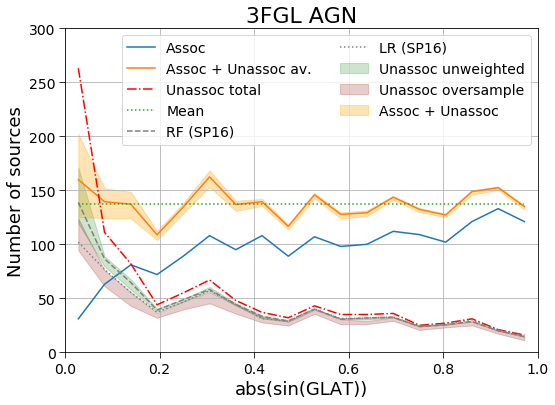

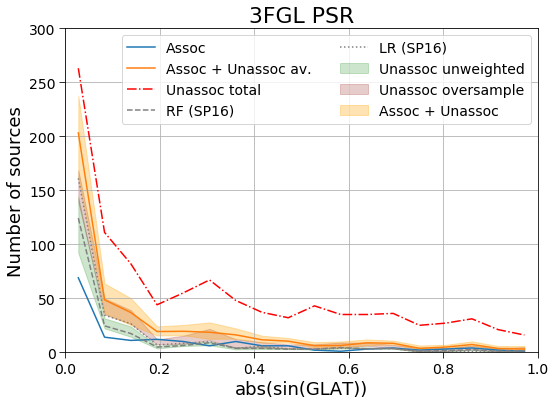

In [79]:
SP_colors = ['violet', 'brown']
SP_lss = ['--', ':']
use_sin_glat = 1
#plotting.setup_figure_pars()
#print(pyplot.rcParams['figure.subplot.left'])
#pyplot.rcParams['figure.subplot.bottom'] = 0.15
unass_lat_tot = np.histogram(sin_glat[unas_mask], bins=sin_bins_unif)[0]
for pop in ['AGN', 'PSR']:
    ass_lat = np.histogram(sin_glat[masks[pop]], bins=sin_bins_unif)[0]
    unass_lat_u = {}
    if add_os:
        unass_lat_o = {}
    unass_lat_av = np.zeros(nbins)
    for alg in algs_u:
        unass_lat_u[alg] = np.histogram(sin_glat[unas_mask], bins=sin_bins_unif, 
                                          weights=cat_df['%s_%s' % (pop, alg)][unas_mask])[0]
        if add_os:
            alg_o = alg + '_O'
            unass_lat_o[alg_o] = np.histogram(sin_glat[unas_mask], bins=sin_bins_unif, 
                                          weights=cat_df['%s_%s' % (pop, alg_o)][unas_mask])[0]

            
            unass_lat_av += (unass_lat_u[alg] + unass_lat_o[alg_o]) / len(algs_u) / 2.
        else:
            unass_lat_av += unass_lat_u[alg] / len(algs_u)
            
    if cat == '3FGL':
        for alg in algs0_SP:
            if pop == 'PSR':
                weights = pcat_SP['%s_P' % alg][unas_mask_SP]
            elif pop == 'AGN':
                weights = 1 - pcat_SP['%s_P' % alg][unas_mask_SP]
            if use_sin_glat:
                unass_lat_SP[alg] = np.histogram(sin_glat_SP[unas_mask_SP], bins=sin_bins_unif, 
                                              weights=weights)[0]
            else:
                unass_lat_SP[alg] = np.histogram(glat_SP[unas_mask_SP], bins=lat_bins_unif, 
                                              weights=weights)[0]
                
    if use_sin_glat:
        xs = sin_bins_unif_c
    else:
        xs = lat_bins_unif_c
    fig = pyplot.figure()
    pyplot.plot(xs, ass_lat, label='Assoc')
    minvs, maxvs = min_max_vs(unass_lat_u)
    pyplot.fill_between(xs, minvs, maxvs, color='green', alpha=0.2, label='Unassoc unweighted')
    if add_os:
        minvs, maxvs = min_max_vs(unass_lat_o)
        pyplot.fill_between(xs, minvs, maxvs, color='darkred', alpha=0.2, label='Unassoc oversample')
    
    unass_lat = {}
    unass_lat.update(unass_lat_u)
    if add_os:
        unass_lat.update(unass_lat_o)
    minvs, maxvs = min_max_vs(unass_lat)
    pyplot.fill_between(xs, ass_lat + minvs, ass_lat + maxvs, color='orange', alpha=0.3, 
                        label='Assoc + Unassoc')
    mean = np.mean(ass_lat + unass_lat_av) * np.ones(nbins)
    pyplot.plot(xs, ass_lat + unass_lat_av, label='Assoc + Unassoc av.')
    #pyplot.errorbar(xs, ass_lat + unass_lat_av, np.sqrt(mean), ls='', marker='s', label='Assoc + Unassoc av.')
    pyplot.plot(xs, unass_lat_tot, ls='-.', color='r', label='Unassoc total')
    

    if pop == 'AGN':
        pyplot.plot(xs, mean, ls=':', label='Mean')
    if cat == '3FGL':
        for i, alg in enumerate(algs0_SP):
            pyplot.plot(xs, unass_lat_SP[alg], ls=SP_lss[i], c='gray', #c=SP_colors[i], 
                        label='%s (SP16)' % alg)


    pyplot.title('%s %s' %(cat, pop))
    pyplot.legend(ncol=2)
    pyplot.grid()
    if use_sin_glat:
        pyplot.xlabel('abs(sin(GLAT))')
        pyplot.xlim(0, 1)
        #x_ticks = fig.axes[0].get_xticks()
        #x_ticks_new = np.around(np.rad2deg(np.arcsin(x_ticks)))
        #fig.axes[0].set_xticks(x_ticks_new)
    else:
        pyplot.xlabel('abs(GLAT)')
        pyplot.xlim(0, 90)
        
    pyplot.ylabel('Number of sources')
    if cat == '3FGL':
        pyplot.ylim(0, 300)
    elif cat == '4FGL':
        pyplot.ylim(0, 400)

    if save_plots:
        fn = '%s/lat_profile_%s_%s%s.pdf' % (plots_folder, pop, cat, estr)
        print('save figure to file: %s' % fn)
        pyplot.savefig(fn)
        if 1:
            cmd = 'cp %s ../ML_3FGL_paper/plots' % fn
            print(cmd)
            os.system(cmd)


In [80]:
x_ticks = fig.axes[0].get_xticks()
x_ticks_new = np.around(np.rad2deg(np.arcsin(x_ticks)))
print(x_ticks, x_ticks_new)

[0.  0.2 0.4 0.6 0.8 1. ] [ 0. 12. 24. 37. 53. 90.]


save figure to file: plots/Accuracies/lon_profile_AGN_3FGL_oversample.pdf
cp plots/Accuracies/lon_profile_AGN_3FGL_oversample.pdf ../ML_3FGL_paper/plots
save figure to file: plots/Accuracies/lon_profile_PSR_3FGL_oversample.pdf
cp plots/Accuracies/lon_profile_PSR_3FGL_oversample.pdf ../ML_3FGL_paper/plots


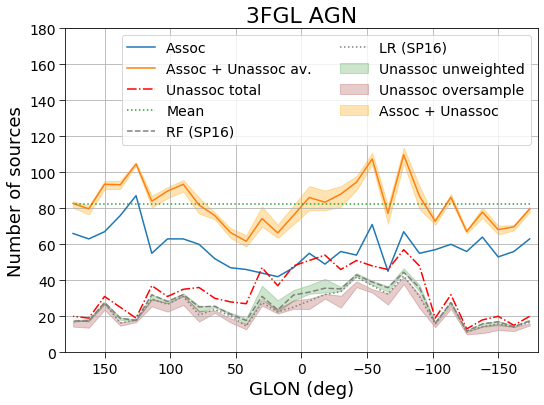

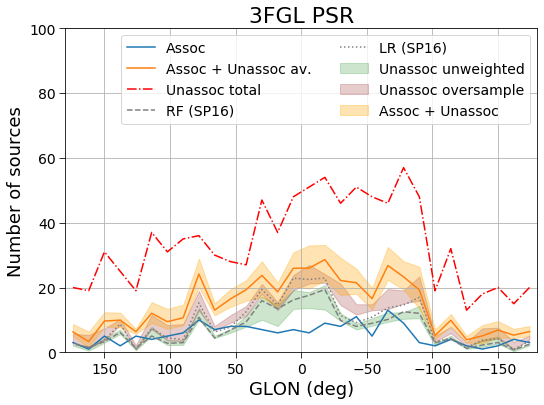

In [81]:
nbins_lon = 30
glon_bins = np.linspace(-180, 180, nbins_lon + 1)
glon_bins_c = (glon_bins[1:] + glon_bins[:-1]) / 2.
# make the range from -180 to 180
glon = cat_df0['GLON'] - 360. * (cat_df0['GLON'] // 180.)

unass_lon_tot = np.histogram(glon[unas_mask], bins=glon_bins)[0]
for pop in ['AGN', 'PSR']:
    ass_lon = np.histogram(glon[masks[pop]], bins=glon_bins)[0]
    unass_lon_u = {}
    unass_lon_SP = {}
    unass_lon_av = np.zeros(nbins_lon)
    if add_os:
        unass_lon_o = {}
        
    for alg in algs_u:
        unass_lon_u[alg] = np.histogram(glon[unas_mask], bins=glon_bins, 
                                          weights=cat_df['%s_%s' % (pop, alg)][unas_mask])[0]
        if add_os:
            alg_o = alg + '_O'
            unass_lon_o[alg_o] = np.histogram(glon[unas_mask], bins=glon_bins, 
                                          weights=cat_df['%s_%s' % (pop, alg_o)][unas_mask])[0]

            
            unass_lon_av += (unass_lon_u[alg] + unass_lon_o[alg_o]) / len(algs_u) / 2.
        else:
            unass_lon_av += (unass_lon_u[alg]) / len(algs_u)

        
    if cat == '3FGL':
        for alg in algs0_SP:
            if pop == 'PSR':
                weights = pcat_SP['%s_P' % alg][unas_mask_SP]
            elif pop == 'AGN':
                weights = 1 - pcat_SP['%s_P' % alg][unas_mask_SP]
            unass_lon_SP[alg] = np.histogram(glon_SP[unas_mask_SP], bins=glon_bins, 
                                              weights=weights)[0]

    xs = glon_bins_c
    pyplot.figure()
    pyplot.plot(xs, ass_lon, label='Assoc')
    minvs, maxvs = min_max_vs(unass_lon_u)
    pyplot.fill_between(xs, minvs, maxvs, color='green', alpha=0.2, label='Unassoc unweighted')
    if add_os:
        minvs, maxvs = min_max_vs(unass_lon_o)
        pyplot.fill_between(xs, minvs, maxvs, color='darkred', alpha=0.2, label='Unassoc oversample')
    
    unass_lon = {}
    unass_lon.update(unass_lon_u)
    if add_os:
        unass_lon.update(unass_lon_o)
    minvs, maxvs = min_max_vs(unass_lon)
    pyplot.fill_between(xs, ass_lon + minvs, ass_lon + maxvs, color='orange', alpha=0.3, 
                        label='Assoc + Unassoc')

    
    mean = np.mean(ass_lon + unass_lon_av) * np.ones(nbins_lon)
    pyplot.plot(xs, ass_lon + unass_lon_av, label='Assoc + Unassoc av.')
    #pyplot.errorbar(xs, ass_lat + unass_lat_av, np.sqrt(mean), ls='', marker='s', label='Assoc + Unassoc av.')
    pyplot.plot(xs, unass_lon_tot, ls='-.', color='r', label='Unassoc total')
    

    if pop == 'AGN':
        pyplot.plot(xs, mean, ls=':', label='Mean')

    if cat == '3FGL':
        for i, alg in enumerate(algs0_SP):
            pyplot.plot(xs, unass_lon_SP[alg], ls=SP_lss[i], c='gray', #c=SP_colors[i], 
                        label='%s (SP16)' % alg)

    pyplot.title('%s %s' % (cat, pop))
    pyplot.legend(ncol=2)
    pyplot.grid()
    pyplot.xlabel('GLON (deg)')
    pyplot.ylabel('Number of sources')
    pyplot.xlim(180, -180)
    if cat == '4FGL':
        if pop == 'AGN':
            pyplot.ylim(0, 250)
        else:
            pyplot.ylim(0, 160)
    else:
        if pop == 'AGN':
            pyplot.ylim(0, 180)
        else:
            pyplot.ylim(0, 100)
        
            
    if save_plots:
        fn = '%s/lon_profile_%s_%s%s.pdf' % (plots_folder, pop, cat, estr)
        print('save figure to file: %s' % fn)
        pyplot.savefig(fn)
        cmd = 'cp %s ../ML_3FGL_paper/plots' % fn
        print(cmd)
        os.system(cmd)
